In [1]:
## Parameters specific to where your folders are and your data
parameter_file = 'params/params.yaml'
import yaml
import sys
import glob
with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
annotation= doc['annotation']
annotation_gtf = doc['annotation_gtf']
tss_file = doc['tss_annotation']

tss_annotation = doc['tss_annotation']


import os

import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm

from os.path import basename
##mpl.use('Agg')
#mpl.style.use('ggplot')
#mpl.style.use('fivethirtyeight')
from Homer import *

print('Number of tissues: ',len(tissues))

('Number of tissues: ', 15)


In [2]:
import Homer

### Plot the CDF of fraction of genes covered

In [3]:
def to_collapse(curr,collapse_mapping):
    collapse = set()
    for i in curr: 
        collapse.add(collapse_mapping[i])
    return list(collapse)

def create_binary(df,tissues,colname="tissues"):
    bin_df = pd.DataFrame(index=df.index,columns=tissues,dtype=bool)
    bin_df[:] = False
    for ind,val in tqdm.tqdm(df.iterrows()):
        bin_df.loc[ind,val["tissues"]] = True
        
    return bin_df

In [4]:
[tissue_map,tissue_map_short]= pickle.load(open("Results/tissue_map.p","rb"))

In [5]:
f_in = 'Results/tss_annotation/geneID_df_02.p' 
gene = pickle.load(open(f_in,"rb"))
gene["tissues"] = gene["samples"].apply(lambda x: to_collapse(x,tissue_map_short))
gene_bin = create_binary(gene,tissues,colname="tissues")

24562it [06:44, 60.75it/s]


In [8]:
## Create CDF of genes
def create_cdf(bin_df):
    ## Steps:
    # 1. Create dictionary of tissue combo to number of genes 
    # 1. Double for loop and get the pairwise union overlap
    # 2. Pop them from list
    # 3. While not done with all columns
         #-Loop through and find the next maximum overlap
         #-Add to dictionary
         #-Pop from list
    cdf_tissues = []
    cdf_number = []
    all_cols = list(bin_df.columns.values)
    max_overlap = 0
    max_combo = ()
    max_num = 0
    for i in all_cols:
        for j in all_cols[1:]:
            overlap =  set((bin_df[bin_df[i]].index)).union(set((bin_df[bin_df[j]].index)))
            if len(overlap) > max_num:
                max_overlap = overlap
                max_num = len(overlap)
                max_combo  = (i,j)



    cdf_tissues.append(max_combo[np.argmax([bin_df[max_combo[0]].sum(),bin_df[max_combo[1]].sum()])])
    cdf_tissues.append(max_combo[np.argmin([bin_df[max_combo[0]].sum(),bin_df[max_combo[1]].sum()])])

    cdf_number.append(max(bin_df[max_combo[0]].sum(),bin_df[max_combo[1]].sum()))
    cdf_number.append(max_num)

    all_cols.remove(max_combo[0])
    all_cols.remove(max_combo[1])

    while len(all_cols) > 0:
        no_addition = True
        for i in all_cols:
            overlap =  max_overlap.union(set((bin_df[bin_df[i]].index)))
            if len(overlap) > max_num:
                max_num = len(overlap)
                max_ind = i
                no_addition = False
        if no_addition:
            break

        max_overlap = max_overlap.union(set((bin_df[bin_df[max_ind]].index)))
        cdf_tissues.append(max_ind)
        cdf_number.append(max_num)
        all_cols.remove(max_ind)
    
    return cdf_number,cdf_tissues
  





In [9]:
cdf_number_gene,cdf_tissues_gene = create_cdf(gene_bin)

In [12]:
if not os.path.exists("Results/Figures"):
    os.mkdir("Results/Figures")
if not os.path.exists("Results/Figures/cdf_tissues"):
    os.mkdir("Results/Figures/cdf_tissues")


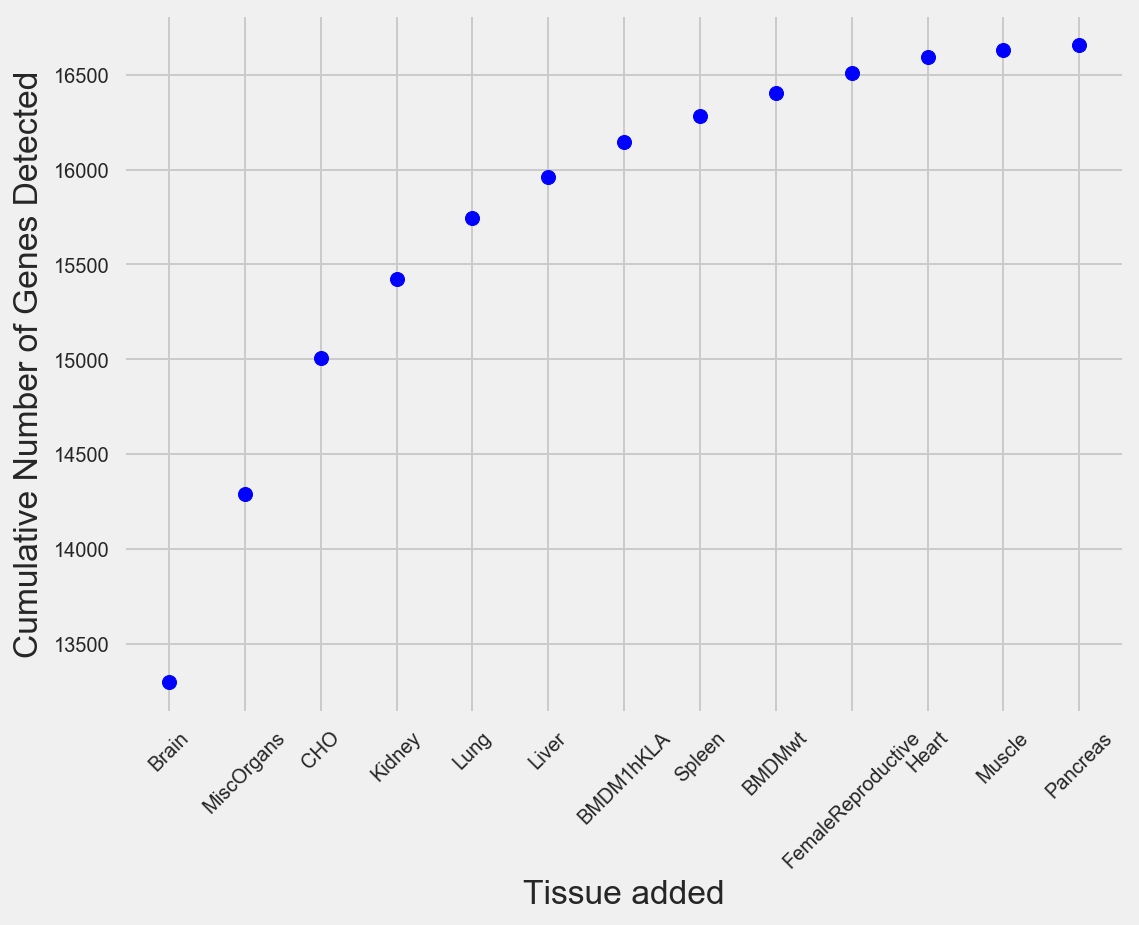

In [40]:
f, ax = plt.subplots()
plt.scatter(np.arange(1,len(cdf_number_gene)+1),cdf_number_gene)
plt.xlabel("Tissue added")
plt.ylabel("Cumulative Number of Genes Detected")
ax.set_xticks(range(1,len(cdf_tissues_gene)+1));
ax.set_xticklabels(cdf_tissues_gene);
ax.tick_params(axis="x",rotation=45)
#plt.xticks(rotation="vertical");
plt.savefig("Results/Figures/cdf_tissues/cdf_geneID_df_02_tissues.png",bbox_inches="tight")
plt.savefig("Results/Figures/cdf_tissues/cdf_geneID_df_02_tissues.svg",bbox_inches="tight")

## Enhancers:
1. Enhancer:  
   i. Annotation as intergenic  
   ii. Distance to TSS > 1000  
   iii. Need to handle same strand/divergent transcription  
2. Filter:  
   i. > 1 CPM  
   ii. > 10 CPM ??  
   iii. > 2 tissues  

In [14]:
import annotation
import helper

In [15]:
## Create binary of expression matrix
def create_binary_from_expr(expr_df,threshold=1):
    bin_df = (expr_df > threshold)
    return bin_df

In [35]:
intergenic = pd.read_csv("Results/merged/samples.merge.anno",sep="\t",index_col=0)
#intergenic["Annotation"].filna(inplace=True)
intergenic = (intergenic["Annotation"].str.contains("Intergenic") & (np.abs(intergenic["Distance to TSS"].fillna(0).astype(int)) > 1000))

expr_df = pd.read_csv("Results/merged/tissues.merge.peaksexpression.log10",sep="\t",index_col = 0)
expr_df = expr_df[expr_df.index.isin(intergenic.index)]
expr_df.head()

,Heart,Spleen,MiscOrgans,FemaleReproductive,CHO,BMDM1hKLA,Brain,Lung,Liver,BMDMwt,Muscle,Kidney,Pancreas
0,0.213256,0.000000,0.191009,0.177054,1.379905,1.92993,0.192445,0.292073,0.000000,0.000000,0.191908,0.289548,0.000000
1,0.000000,0.568176,0.658306,0.704141,0.000000,0.00000,0.365353,0.875407,0.211156,0.000000,0.160073,0.206016,0.000000
2,0.000000,0.272654,0.191009,0.649540,1.269561,0.00000,0.285237,0.439970,0.000000,0.822168,0.251895,0.377071,0.299942
3,0.213256,0.582778,0.592983,0.556972,0.347363,0.00000,0.633209,0.256951,0.000000,0.536558,0.300486,0.216445,0.380588
4,0.858835,1.743575,1.998797,1.219034,0.698374,0.00000,1.707648,0.729080,0.945179,0.641474,1.198274,0.838893,1.141311


## 1. Threshold = 10 (log10=1)
   ## Distance to gene > 1000

In [36]:
bin_df_enh = create_binary_from_expr(expr_df,threshold=1)

cdf_number,cdf_tissues = create_cdf(bin_df_enh)

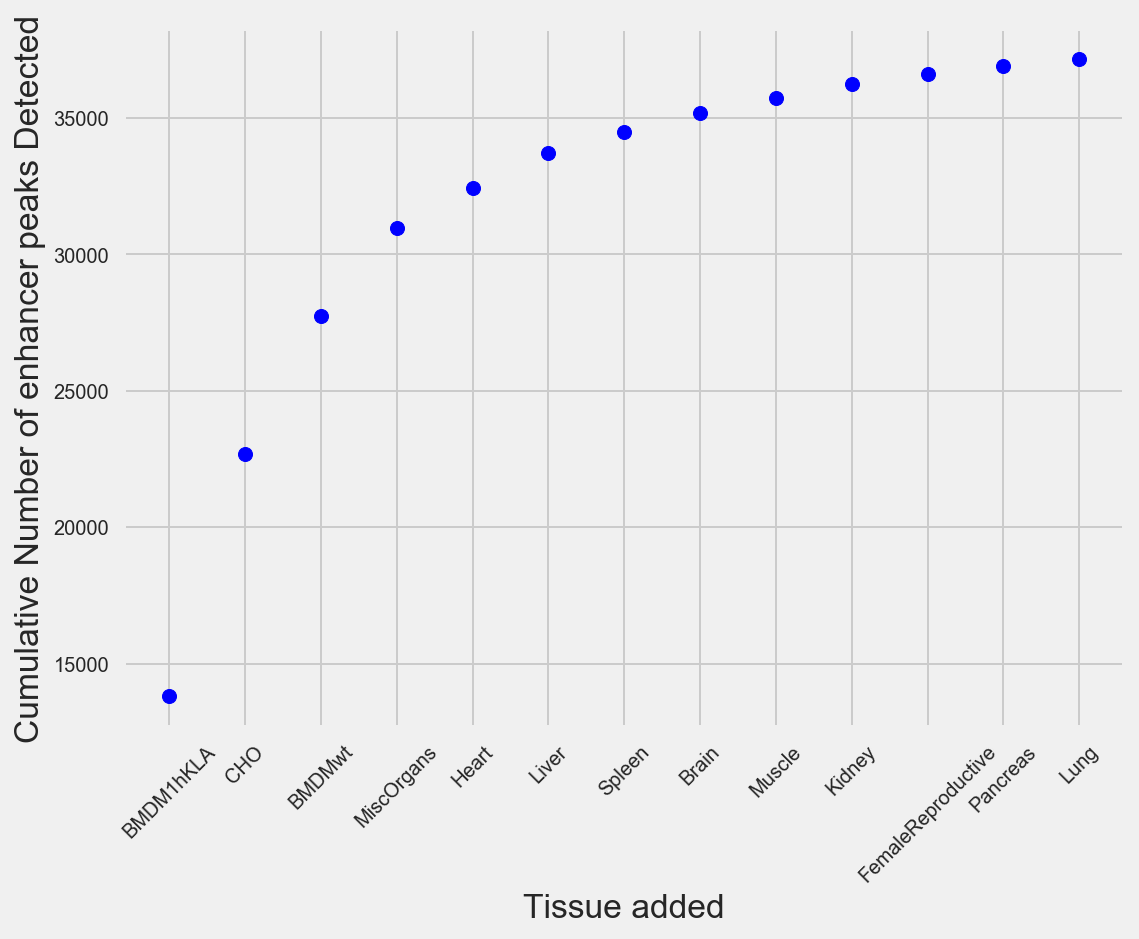

In [41]:
f, ax = plt.subplots()
plt.scatter(np.arange(1,len(cdf_number)+1),cdf_number)
plt.xlabel("Tissue added")
plt.ylabel("Cumulative Number of enhancer peaks Detected")
ax.set_xticks(range(1,len(cdf_tissues)+1));
ax.set_xticklabels(cdf_tissues);
ax.tick_params(axis="x",rotation=45)
#plt.xticks(rotation="vertical");
plt.savefig("Results/Figures/cdf_tissues/cdf_enhancers_tissues.png",bbox_inches="tight")
plt.savefig("Results/Figures/cdf_tissues/cdf_enhancers_tissues.svg",bbox_inches="tight")

In [38]:
cdf_tissues

['BMDM1hKLA',
 'CHO',
 'BMDMwt',
 'MiscOrgans',
 'Heart',
 'Liver',
 'Spleen',
 'Brain',
 'Muscle',
 'Kidney',
 'FemaleReproductive',
 'Pancreas',
 'Lung']